# Anomaly Detection on MVTec AD (Pill Dataset) using Autoencoder

## Objective
This notebook demonstrates how to perform Anomaly Detection using a Convolutional Autoencoder. The goal is to train a model on "good" (normal) images so that it learns to reconstruct them well. When the model encounters an anomalous image (defect), the reconstruction error will be high, allowing us to detect the anomaly.

## Dataset
We use the **MVTec AD** dataset, specifically the **Pill** category.

In [ ]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt

from PIL import Image

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchsummary import summary
from torch.utils.data.dataset import Subset
from torch import nn

# Download and extract the data

In [ ]:
# --- Download Data ---
# We download the 'pill' category from the MVTec AD dataset.
# The url points to the specific xz compressed tarball.
url = "https://www.mydrive.ch/shares/43421/11a215a5749fcfb75e331ddd5f8e43ee/download/420938129-1629953099/pill.tar.xz"
filename = "pill.tar.xz"

if not os.path.exists(filename):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, filename)
    print("Download complete.")

# --- Extract Data ---
# Extract the contents of the tarball to the current directory.
if not os.path.exists('pill'):
    print("Extracting dataset...")
    with tarfile.open(filename) as f:
        f.extractall('.')
    print("Extraction complete.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ln -s /content/drive/MyDrive/MVTec_AD_Full /content/data

ln: failed to create symbolic link '/content/data/MVTec_AD_Full': File exists


# Visualize some samples

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image # here you can use cv2.imread/ skimage instead of PIL.Image.open

image_path = '/content/data/pill/test/crack/000.png'
image = Image.open(image_path)
print(image.size)

(800, 800)


torch.Size([3, 224, 224])


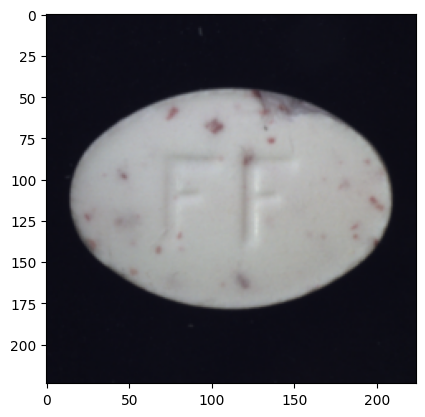

In [ ]:
from torchvision.transforms import transforms

# Define the transformation pipeline using torchvision.transforms.Compose
transform = transforms.Compose([
    transforms.Resize((224,224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor()          # Convert the image to a PyTorch tensor and divide by 255.0
])

# Assuming 'image' is a PIL image object
# Apply the defined transformation pipeline to the image
image = transform(image)

# Print the shape of the transformed image tensor
print(image.shape)

# Plot the transformed image
# Permute the dimensions to (height, width, channels) as matplotlib expects
plt.imshow(image.permute(1, 2, 0))
plt.show()


## Memory consumed by the tensor

In [ ]:
# Calculate the memory usage
memory_usage = image.numel() * image.element_size()

# Print the memory usage
print(f"Memory usage of the tensor: {memory_usage * 279//1024} KB") # 279 is the number of samples we have in the dataset

Memory usage of the tensor: 164052 KB


In [ ]:
from torchvision.datasets import ImageFolder

# Define the path to the directory containing the training images
train_image_path = '/content/data/pill/train'

# Load the training dataset using the ImageFolder dataset class.
# ImageFolder automatically loads images from subdirectories (each subdirectory is treated as a class)
# and applies the specified transformations.
good_dataset = ImageFolder(root=train_image_path, transform=transform)

# Access a sample from the dataset to verify its structure.
x, y = good_dataset[0]  # x: preprocessed image data, y: corresponding label (class index)

print("Image Shape:", x.shape)
print("Label:", y)


Image Shape: torch.Size([3, 224, 224])
Label: 0


# Train test split for the autoencoder

In [ ]:
import torch

# Split the dataset into training and testing subsets
# The `torch.utils.data.random_split` function randomly splits a dataset into non-overlapping subsets
# The first argument `good_dataset` is the dataset to be split
# The second argument `[0.8, 0.2]` specifies the sizes of the subsets. Here, 80% for training and 20% for testing.
train_dataset, test_dataset = torch.utils.data.random_split(good_dataset, [0.8, 0.2])

# Print the lengths of the original dataset, training subset, and testing subset
print("Total number of samples in the original dataset:", len(good_dataset))
print("Number of samples in the training subset:", len(train_dataset))
print("Number of samples in the testing subset:", len(test_dataset))

Total number of samples in the original dataset: 267
Number of samples in the training subset: 214
Number of samples in the testing subset: 53


## Using dataloader for efficient data loading during training

In [ ]:
import torch
from torch.utils.data import DataLoader

# Assuming train_dataset and test_dataset are PyTorch datasets containing image data and labels

# Set the batch size
BS = 16

# Create data loaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=True)

# Get a batch of images and labels from the training loader
image_batch, label_batch = next(iter(train_loader))

# Print the shape of the input images and labels
print(f'Shape of input images: {image_batch.shape}')
print(f'Shape of labels: {label_batch.shape}')
# Calculate the memory usage
memory_usage = image_batch.numel() * image_batch.element_size()

# Print the memory usage
print(f"Memory usage of the tensor: {memory_usage//1024} KB")

Shape of input images: torch.Size([16, 3, 224, 224])
Shape of labels: torch.Size([16])
Memory usage of the tensor: 9408 KB


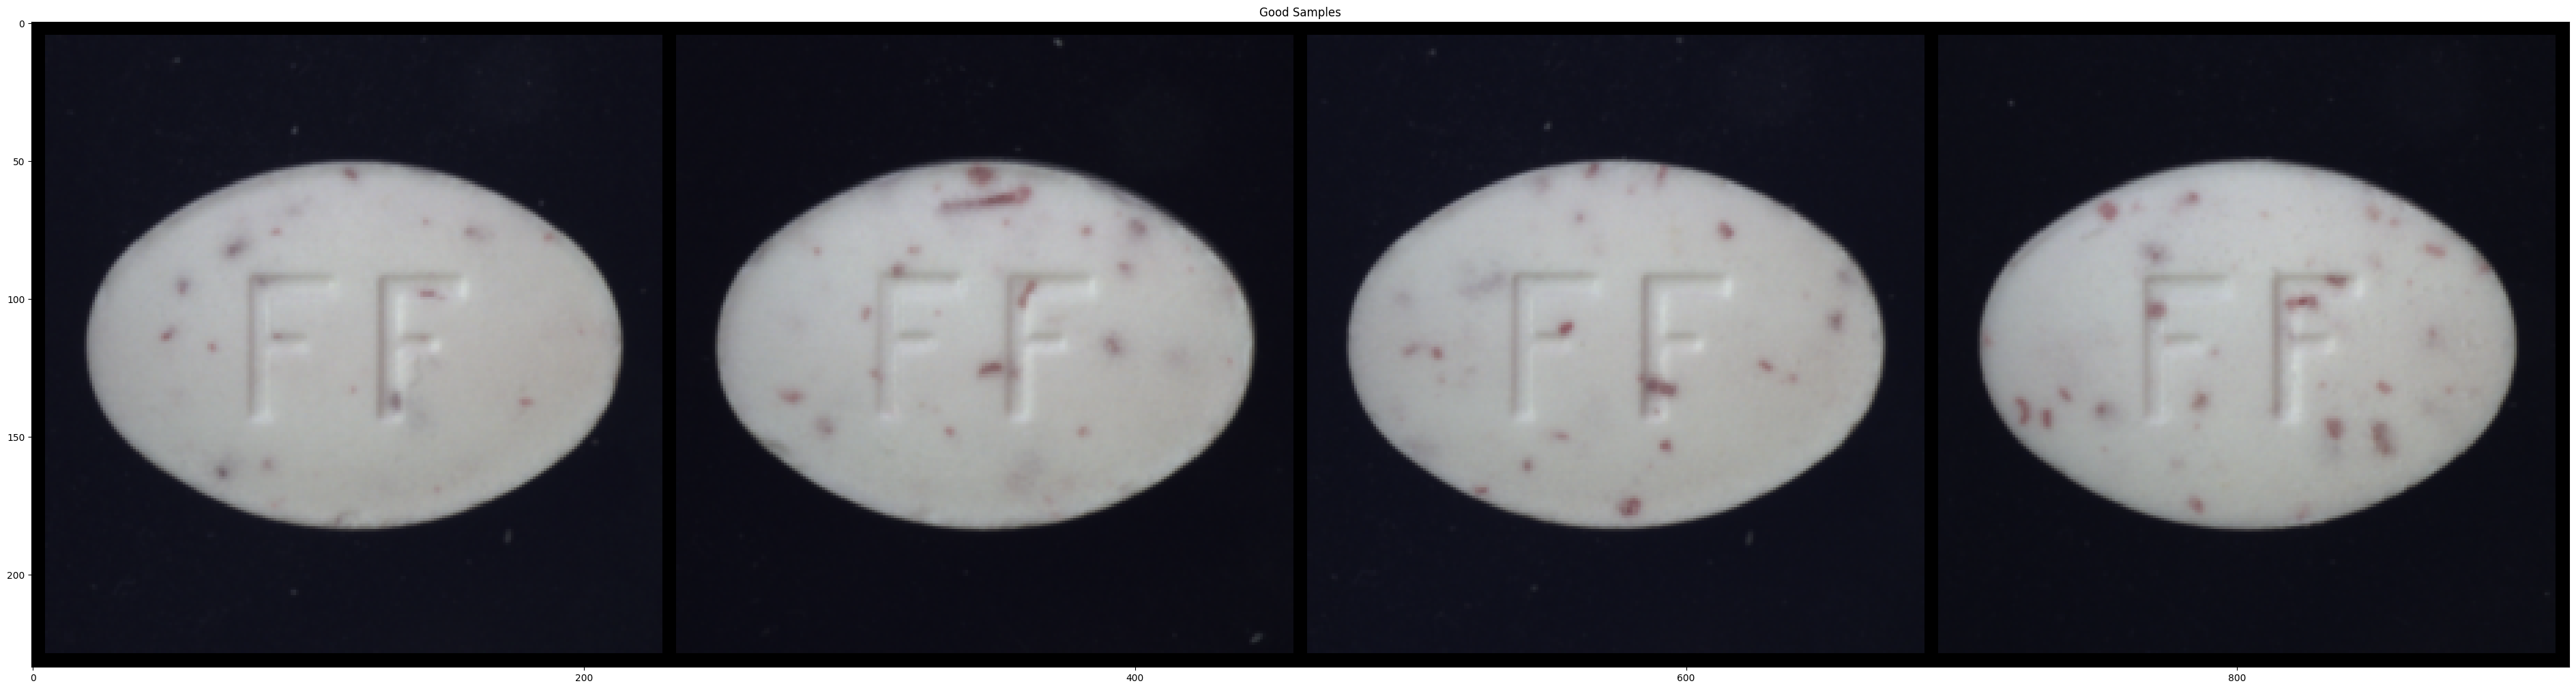

In [ ]:
# Set the figure size
plt.figure(figsize=(12*4, 48*4))

# Create a grid of images from the image batch and visualize it
grid = torchvision.utils.make_grid(image_batch[0:4], padding=5, nrow=4)
plt.imshow(grid.permute(1, 2, 0))  # Permute dimensions to (height, width, channels) for visualization
plt.title('Good Samples')  # Set the title of the plot
plt.show()  # Show the plot

# Train autoencoder model

In [ ]:
import torch.nn.functional as F
from torch import nn


input_image = Image.open('/content/data/pill/train/good/000.png')
input_image = transform(input_image) # resizes the image, converts to a tensor
# print(input_image.shape)
# plt.imshow(input_image.permute(1,2,0))
# plt.show()

input_image = input_image.unsqueeze(0) # adds an extra dimension (represnting batch size)
# print(input_image.shape)

c1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4)
x = c1(input_image)
print(x.shape)
ap1 = nn.AvgPool2d(kernel_size=2, stride=2 )
x = ap1(x)
print(x.shape)
c2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4)
ap2 = nn.AvgPool2d(kernel_size=2, stride=2 )
x= ap2(c2(x))
print(x.shape)
c3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3 )
ap3 = nn.AvgPool2d(kernel_size=2, stride=2 )
x = ap3(c3(x))
print(x.shape)

c4 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=4, stride=2, output_padding=1 )
x = c4(x)
print(x.shape)
c5 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=5, stride=2, output_padding=1 )
x = c5(x)
print(x.shape)
c6 = nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=5, stride=2, output_padding=1 )
x = c6(x)
print(x.shape)

torch.Size([1, 128, 221, 221])
torch.Size([1, 128, 110, 110])
torch.Size([1, 256, 53, 53])
torch.Size([1, 256, 25, 25])
torch.Size([1, 256, 53, 53])
torch.Size([1, 128, 110, 110])
torch.Size([1, 3, 224, 224])


## Model Architecture

In [ ]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder part of the autoencoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4), # Input: 3 channels, Output: 128 channels
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2), # Downsamples the feature maps
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        # Decoder part of the autoencoder
        self.decoder = nn.Sequential(
            # Transposed convolutional layers to upsample and reconstruct the image
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, output_padding=1 ),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=5, stride=2, output_padding=1), # Output: 3 channels (for RGB image)
            nn.Sigmoid() # Sigmoid activation to keep pixel values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Test the autoencoder architecture with a sample input
model = Autoencoder()
input_image = torch.randn(1, 3, 224, 224)  # Sample input image (batch_size, channels, height, width)
output_image = model(input_image)
print(output_image.shape)  # Print the shape of the output image, should match input shape


torch.Size([1, 3, 224, 224])


In [ ]:
# ckpoints = torch.load('simple_autoencoder_l2_loss.pth')
# model.load_state_dict(ckpoints)

FileNotFoundError: [Errno 2] No such file or directory: 'simple_autoencoder_l2_loss.pth'

In [ ]:
# Define the loss function and optimizer

model.cuda() # Move the model to the GPU for faster computation
criterion = torch.nn.MSELoss() # Mean Squared Error Loss, commonly used for autoencoders
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam optimizer with a learning rate of 0.001


# Training loop

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Loss: 0.0233, Validation Loss: 0.0220
Epoch [6/100], Loss: 0.0073, Validation Loss: 0.0072
Epoch [11/100], Loss: 0.0046, Validation Loss: 0.0045
Epoch [16/100], Loss: 0.0029, Validation Loss: 0.0029
Epoch [21/100], Loss: 0.0024, Validation Loss: 0.0026
Epoch [26/100], Loss: 0.0023, Validation Loss: 0.0024
Epoch [31/100], Loss: 0.0022, Validation Loss: 0.0022
Epoch [36/100], Loss: 0.0026, Validation Loss: 0.0022
Epoch [41/100], Loss: 0.0019, Validation Loss: 0.0020
Epoch [46/100], Loss: 0.0019, Validation Loss: 0.0019
Epoch [51/100], Loss: 0.0018, Validation Loss: 0.0019
Epoch [56/100], Loss: 0.0018, Validation Loss: 0.0018
Epoch [61/100], Loss: 0.0018, Validation Loss: 0.0018
Epoch [66/100], Loss: 0.0016, Validation Loss: 0.0017
Epoch [71/100], Loss: 0.0018, Validation Loss: 0.0017
Epoch [76/100], Loss: 0.0016, Validation Loss: 0.0016
Epoch [81/100], Loss: 0.0016, Validation Loss: 0.0016
Epoch [86/100], Loss: 0.0015, Validation Loss: 0.0016
Epoch [91/100], Loss: 0.0015, 

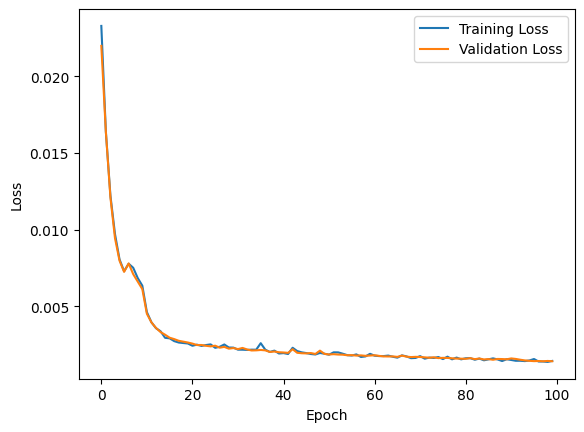

In [ ]:
# Define a list to store training loss and validation loss
Loss = []
Validation_Loss = []


num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set model to training mode
    for img, _ in train_loader:
        img = img.cuda()

        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad() #clears the gradients of all optimized tensors.  This step is necessary because gradients are accumulated by default in PyTorch, and we want to compute fresh gradients for the current batch of data.
        loss.backward() # This line computes the gradients of the loss function with respect to the model parameters. These gradients are used to update the model parameters during optimization.
        optimizer.step() # This line updates the model parameters using the computed gradients.
    Loss.append(loss.item())


    # Calculate validation loss
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for img, _ in test_loader:
            img = img.cuda()
            output = model(img)
            val_loss = criterion(output, img)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)

    if epoch % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss_avg))

plt.plot(Loss, label='Training Loss')
plt.plot(Validation_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Save the model
torch.save(model.state_dict(), 'simple_autoencoder_l2_loss.pth')
model.eval()

# ckpoints = torch.load('simple_autoencoder_l2_loss.pth')
# model.load_state_dict(ckpoints)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

## Reconstruction of good images

torch.Size([16, 224, 224])


<Figure size 1600x1200 with 0 Axes>

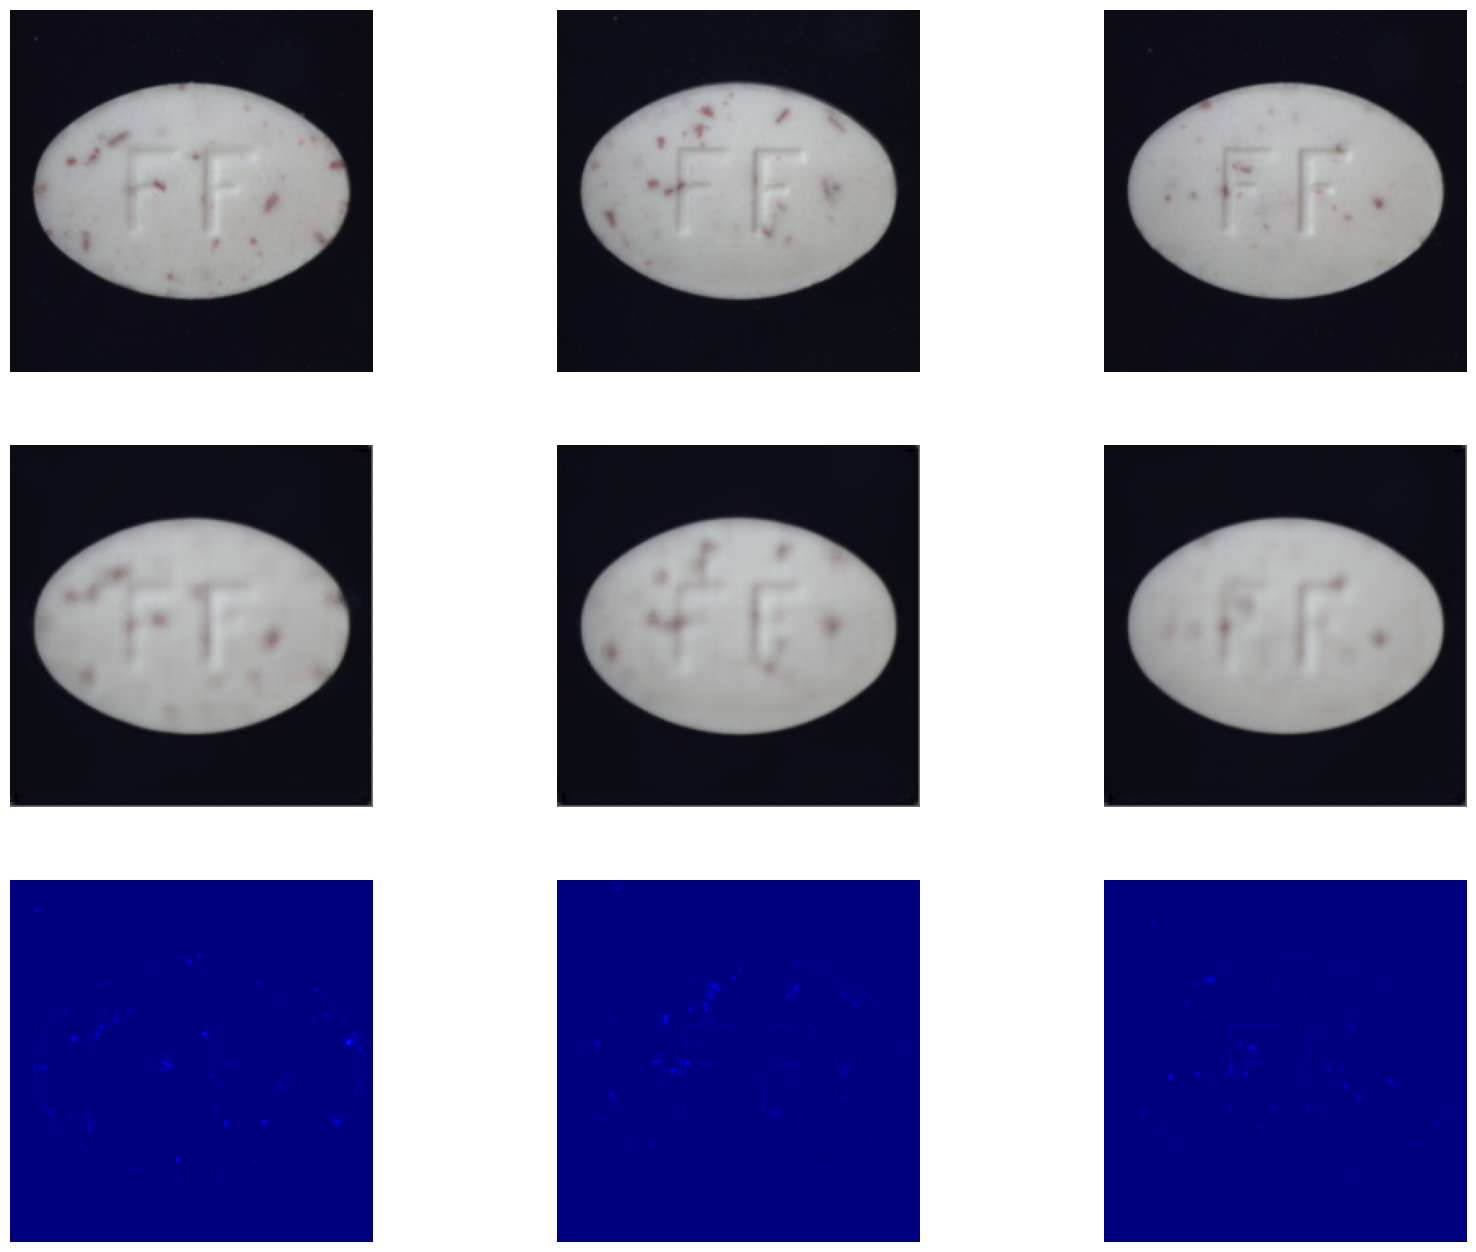

In [ ]:
with torch.no_grad():
    for data, _ in train_loader:
        data = data.cuda()
        recon = model(data)
        break

recon_error =  ((data-recon)**2).mean(axis=1)
print(recon_error.shape)

plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10,0:-10].cpu().numpy(), cmap='jet',vmax= torch.max(recon_error[i])) #[0:-10,0:-10]
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()

## Reconstruction of bad images

# Obtain the fault detection HEATMAP using AE

<Figure size 1600x1200 with 0 Axes>

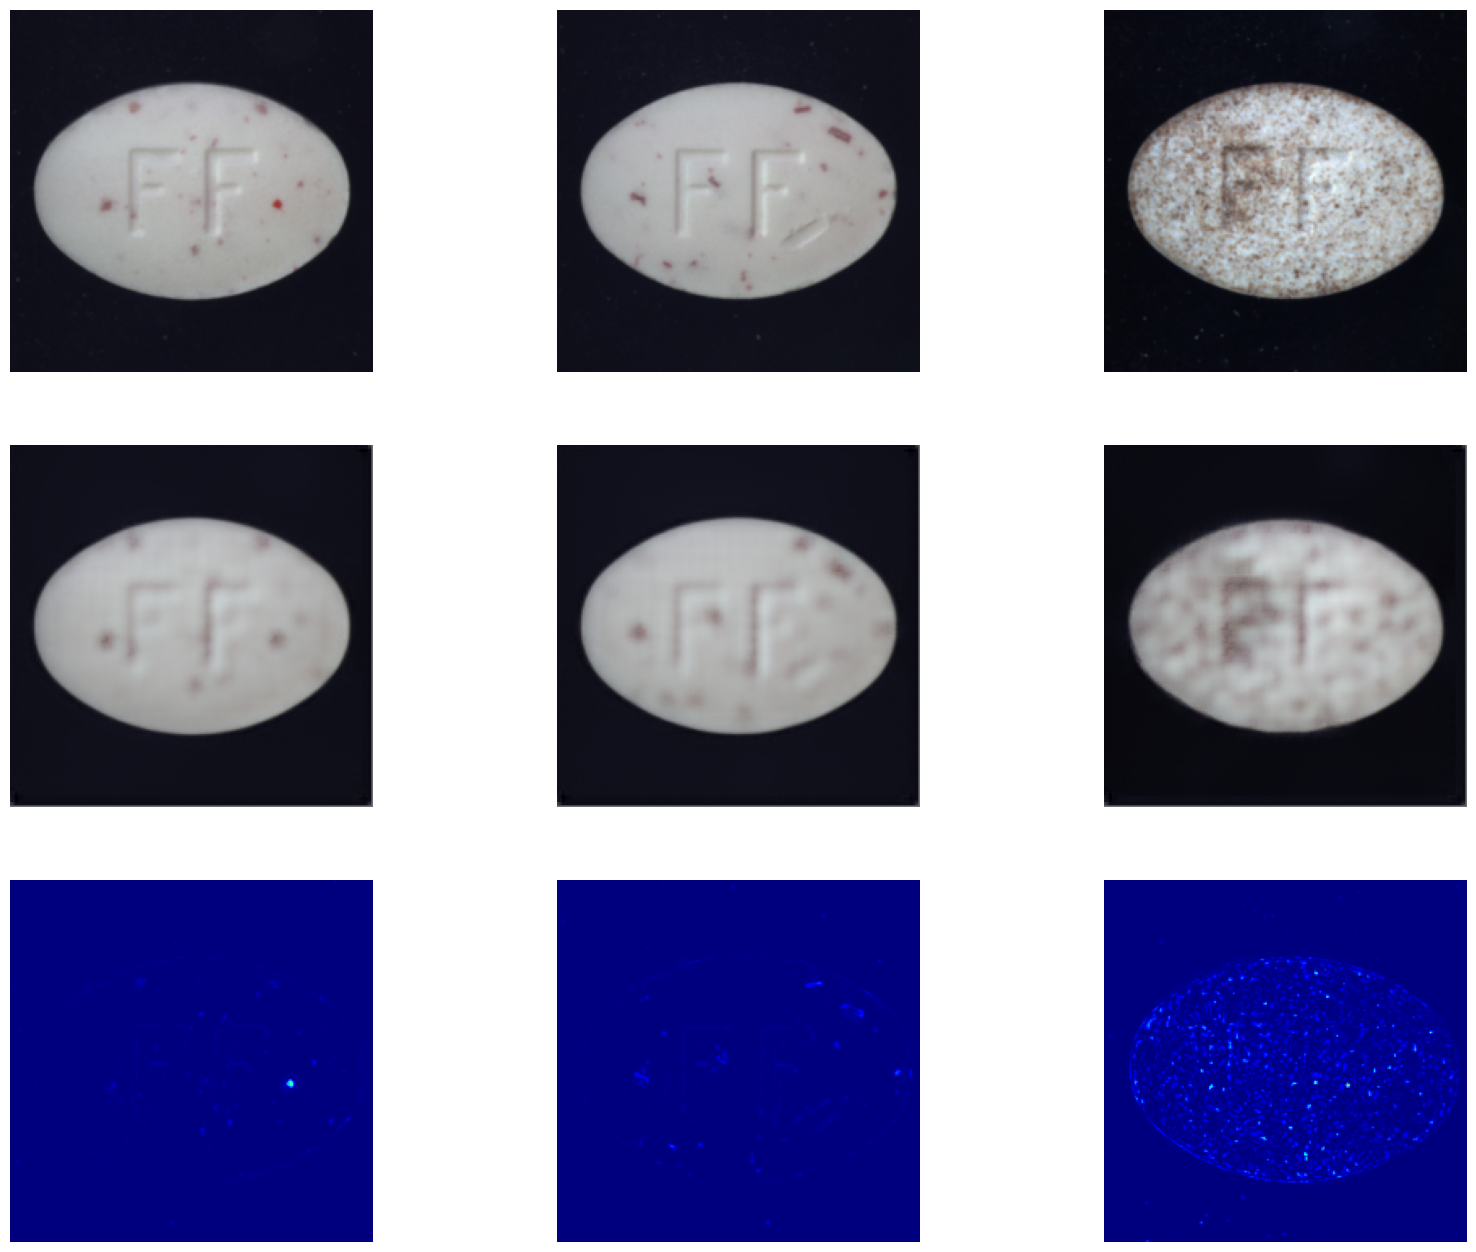

In [ ]:
test_image_1 = transform(Image.open(r'/content/data/pill/test/color/000.png'))
test_image_2 = transform(Image.open(r'/content/data/pill/test/scratch/000.png'))
test_image_3 = transform(Image.open(r'/content/data/pill/test/pill_type/000.png'))

data = torch.stack([test_image_1,test_image_2, test_image_3])

with torch.no_grad():
    data = data.cuda()
    recon = model(data)

recon_error =  ((data-recon)**2).mean(axis=1)

plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10,0:-10].cpu().numpy(), cmap='jet',vmax= torch.max(recon_error[i]))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()


# Obtain the fault detection accuracy

In [ ]:
RECON_ERROR=[]
with torch.no_grad():
    for data, _ in train_loader:
        data = data.cuda()
        recon = model(data)
        data_recon_squared_mean =  ((data-recon)**2).mean(axis=(1))[:,0:-10,0:-10].mean(axis=(1,2))

        RECON_ERROR.append(data_recon_squared_mean)

RECON_ERROR = torch.cat(RECON_ERROR).cpu().numpy()

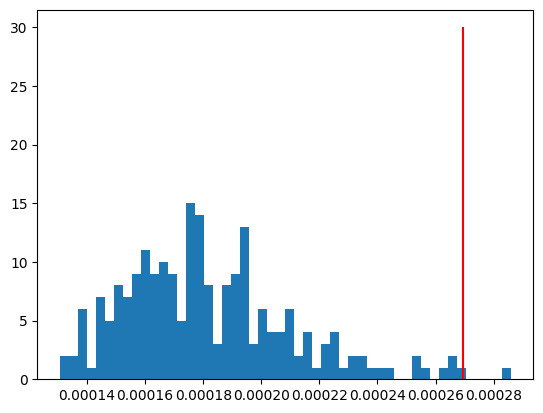

In [ ]:
best_threshold = np.mean(RECON_ERROR) + 3 * np.std(RECON_ERROR)

plt.hist(RECON_ERROR,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

In [ ]:
y_true=[]
y_pred=[]
y_score=[]

model.eval()

with torch.no_grad():

    test_path = Path('/content/data/pill/test')

    for path in test_path.glob('*/*.png'):
        fault_type = path.parts[-2]
        # if fault_type != 'good':
        test_image = transform(Image.open(path)).cuda().unsqueeze(0)
        recon_image = model(test_image)

        # y_score_image =
        y_score_image =  ((test_image - recon_image)**2).mean(axis=(1))[:,0:-10,0:-10].mean()

        y_pred_image = 1*(y_score_image >= best_threshold)

        y_true_image = 0 if fault_type == 'good' else 1

        y_true.append(y_true_image)
        y_pred.append(y_pred_image.cpu())
        y_score.append(y_score_image.cpu())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)


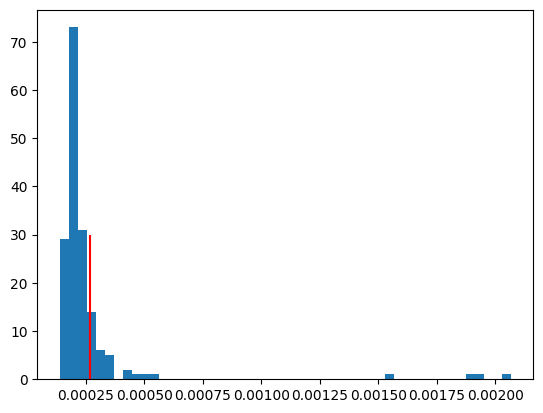

In [ ]:
plt.hist(y_score,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

## Visualization of Results

AUC-ROC Score: 0.817239498090562


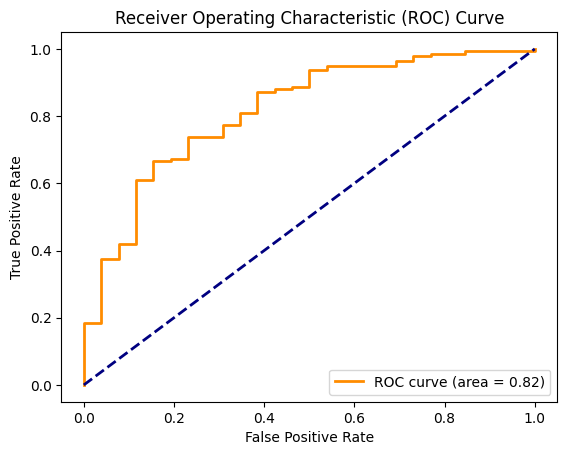

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn as sns



# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



# Using a ResNet for anomaly detection

a powerful alternative to Autoencoders. Instead of learning to "reconstruct" the image, you use the pre-trained ResNet to extract deep features (embeddings) from the images.

The logic changes slightly:

* Autoencoder: Anomaly = High Reconstruction Error (Input - Output).

* ResNet (Feature Matching): Anomaly = Large Distance from "Normal" Features.

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim as optim


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_image_path = Path('/content/data/pill/train')

good_dataset = ImageFolder(root=train_image_path, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(good_dataset, [0.8, 0.2])

# Set the batch size
BS = 16

# Create data loaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=True)

### Load a pretrained Resnet Model

In [ ]:
class resnet_feature_extractor(torch.nn.Module):
    def __init__(self):
        """This class extracts the feature maps from a pretrained Resnet model."""
        super(resnet_feature_extractor, self).__init__()
        # Load a pre-trained ResNet-50 model with default weights
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)

        # Set the model to evaluation mode
        self.model.eval()
        # Freeze all parameters in the ResNet model as we only need features
        for param in self.model.parameters():
            param.requires_grad = False

        # List to store extracted feature maps
        self.features = []

        # Define a hook function to capture intermediate feature maps
        def hook(module, input, output) -> None:
            """This hook saves the extracted feature map on self.features."""
            self.features.append(output)

        # Register forward hooks to capture feature maps from specific layers
        self.model.layer2[-1].register_forward_hook(hook)
        self.model.layer3[-1].register_forward_hook(hook)

    def forward(self, input):

        self.features = [] # Clear features from previous runs
        with torch.no_grad(): # Disable gradient calculation to save memory and speed up computation
            _ = self.model(input) # Pass input through the model, features are captured by hooks

        # Average pooling layer for feature map processing
        self.avg = torch.nn.AvgPool2d(3, stride=1)
        # Determine the size for adaptive average pooling based on the first feature map
        fmap_size = self.features[0].shape[-2]         # Feature map sizes h, w
        self.resize = torch.nn.AdaptiveAvgPool2d(fmap_size) # Resize all feature maps to a consistent size

        # Resize and concatenate the feature maps from different layers
        resized_maps = [self.resize(self.avg(fmap)) for fmap in self.features]
        patch = torch.cat(resized_maps, 1)            # Merge the resized feature maps along the channel dimension

        return patch


torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])
torch.Size([1, 1536, 28, 28])


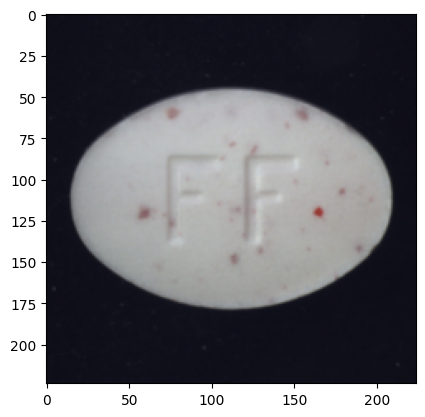

In [ ]:
image = Image.open(r'/content/data/pill/test/color/000.png')
image = transform(image).unsqueeze(0)

backbone = resnet_feature_extractor()
feature = backbone(image)

print(backbone.features[0].shape)
print(backbone.features[1].shape)

print(feature.shape)

plt.imshow(image[0].permute(1,2,0))

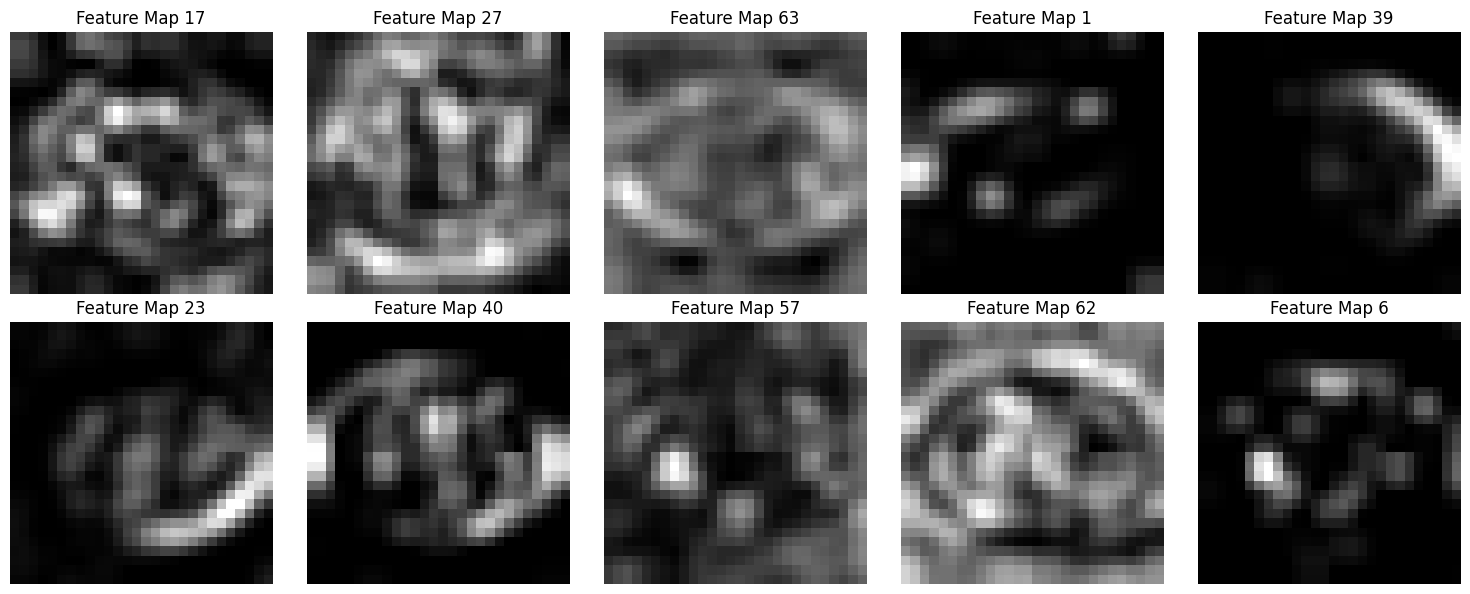

In [ ]:
# Select 10 random indices for feature maps to visualize
indices = torch.randperm(feature.shape[1])[:10] # Ensure indices are within the feature map channels

# Plot the selected feature maps
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(indices):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(feature[0,idx].detach().cpu(), cmap='gray') # Detach and move to CPU for plotting
    axes[row, col].set_title(f'Feature Map {idx}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()


### The autoencoder model

In [ ]:
import torch.nn as nn

class FeatCAE(nn.Module):
    """Autoencoder designed to compress and reconstruct ResNet features."""

    def __init__(self, in_channels=1536, latent_dim=100, is_bn=True):
        super(FeatCAE, self).__init__()

        # Encoder part of the feature autoencoder
        encoder_layers = []
        encoder_layers += [nn.Conv2d(in_channels, (in_channels + 2 * latent_dim) // 2, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            encoder_layers += [nn.BatchNorm2d(num_features=(in_channels + 2 * latent_dim) // 2)]
        encoder_layers += [nn.ReLU()]
        encoder_layers += [nn.Conv2d((in_channels + 2 * latent_dim) // 2, 2 * latent_dim, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            encoder_layers += [nn.BatchNorm2d(num_features=2 * latent_dim)]
        encoder_layers += [nn.ReLU()]
        encoder_layers += [nn.Conv2d(2 * latent_dim, latent_dim, kernel_size=1, stride=1, padding=0)]

        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder part of the feature autoencoder
        decoder_layers = []
        decoder_layers += [nn.Conv2d(latent_dim, 2 * latent_dim, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            decoder_layers += [nn.BatchNorm2d(num_features=2 * latent_dim)]
        decoder_layers += [nn.ReLU()]
        decoder_layers += [nn.Conv2d(2 * latent_dim, (in_channels + 2 * latent_dim) // 2, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            decoder_layers += [nn.BatchNorm2d(num_features=(in_channels + 2 * latent_dim) // 2)]
        decoder_layers += [nn.ReLU()]
        decoder_layers += [nn.Conv2d((in_channels + 2 * latent_dim) // 2, in_channels, kernel_size=1, stride=1, padding=0)]

        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
model = FeatCAE(in_channels=1536, latent_dim=100).cuda()
backbone.cuda()
# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
ckpoints = torch.load('autoencoder_with_resnet_deep_features.pth')
model.load_state_dict(ckpoints)

model.eval()

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Loss: 0.1313, Validation Loss: 0.2502
Epoch [6/50], Loss: 0.0361, Validation Loss: 0.0379
Epoch [11/50], Loss: 0.0298, Validation Loss: 0.0300
Epoch [16/50], Loss: 0.0262, Validation Loss: 0.0264
Epoch [21/50], Loss: 0.0241, Validation Loss: 0.0236
Epoch [26/50], Loss: 0.0227, Validation Loss: 0.0220
Epoch [31/50], Loss: 0.0208, Validation Loss: 0.0213
Epoch [36/50], Loss: 0.0189, Validation Loss: 0.0195
Epoch [41/50], Loss: 0.0185, Validation Loss: 0.0193
Epoch [46/50], Loss: 0.0187, Validation Loss: 0.0182


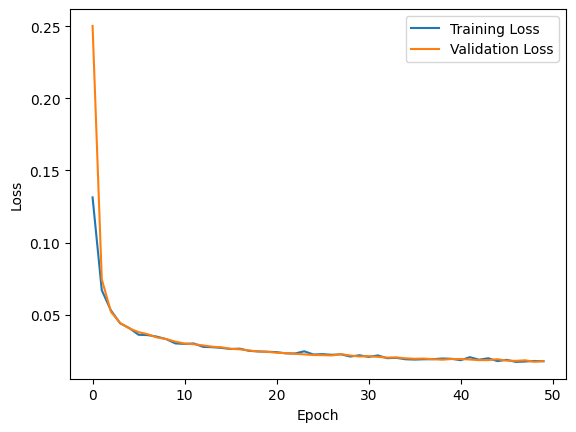

In [ ]:
# Define a list to store training loss and validation loss for plotting
Loss = []
Validation_Loss = []

num_epochs = 50
for epoch in tqdm(range(num_epochs)):
    model.train() # Set model to training mode
    for data,_ in train_loader:
        with torch.no_grad():
            # Extract features from the pre-trained ResNet backbone
            features = backbone(data.cuda())

        # Forward pass through the feature autoencoder
        output = model(features)
        # Compute the reconstruction loss between original and reconstructed features
        loss = criterion(output, features)

        # Backpropagation and optimization step
        optimizer.zero_grad() # Clear previous gradients
        loss.backward()       # Compute gradients
        optimizer.step()      # Update model parameters
    Loss.append(loss.item())

    # Calculate validation loss for monitoring performance
    model.eval()  # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation for validation
        val_loss_sum = 0.0
        num_batches = 0
        for data, _ in test_loader:
            features = backbone(data.cuda())
            output = model(features)
            val_loss = criterion(output, features)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)

    # Print progress every 5 epochs
    if epoch % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss_avg))

# Plot the training and validation loss curves
plt.plot(Loss, label='Training Loss')
plt.plot(Validation_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
torch.save(model.state_dict(), 'autoencoder_resnet_deep_features.pth')

### Prediction of heatmap

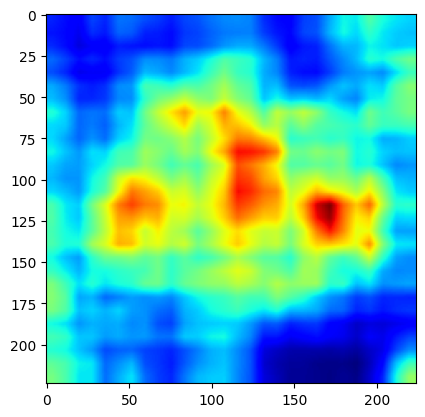

In [ ]:
image = Image.open('/content/data/pill/test/color/000.png')
image = transform(image).unsqueeze(0)

with torch.no_grad():
    features = backbone(image.cuda())
    recon = model(features)

recon_error =  ((features-recon)**2).mean(axis=(1)).unsqueeze(0)

segm_map = torch.nn.functional.interpolate(     # Upscale by bi-linaer interpolation to match the original input resolution
                recon_error,
                size=(224, 224),
                mode='bilinear'
            )

plt.imshow(segm_map.squeeze().cpu().numpy(), cmap='jet')
plt.show()

### For Normal images

In [ ]:
def decision_function(segm_map):

    mean_top_10_values = []

    for map in segm_map:
        # Flatten the tensor
        flattened_tensor = map.reshape(-1)

        # Sort the flattened tensor along the feature dimension (descending order)
        sorted_tensor, _ = torch.sort(flattened_tensor,descending=True)

        # Take the top 10 values along the feature dimension
        mean_top_10_value = sorted_tensor[:10].mean()

        mean_top_10_values.append(mean_top_10_value)

    return torch.stack(mean_top_10_values)

In [ ]:
model.eval() # Set the model to evaluation mode

RECON_ERROR=[]
for data,_ in train_loader:

    with torch.no_grad():
        features = backbone(data.cuda()).squeeze() # Extract features from the backbone
        # Forward pass through the feature autoencoder
        recon = model(features)

    # Calculate the reconstruction error for segmentation map
    # The error is calculated as the mean squared difference between original and reconstructed features
    # A small border (3 pixels) is cropped to focus on relevant areas.
    segm_map =  ((features-recon)**2).mean(axis=(1))[:,3:-3,3:-3]

    # Apply the decision function to get the anomaly score
    anomaly_score = decision_function(segm_map)

    RECON_ERROR.append(anomaly_score)

# Concatenate all anomaly scores and move to CPU for NumPy conversion
RECON_ERROR = torch.cat(RECON_ERROR).cpu().numpy()


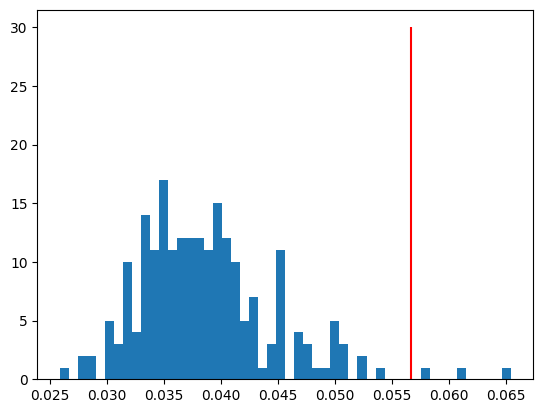

In [ ]:
best_threshold = np.mean(RECON_ERROR) + 3 * np.std(RECON_ERROR)

heat_map_max, heat_map_min = np.max(RECON_ERROR), np.min(RECON_ERROR)

plt.hist(RECON_ERROR,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()


### For Test Images

In [ ]:
y_true=[] # List to store true labels (0 for good, 1 for anomalous)
y_pred=[] # List to store predicted labels (0 for good, 1 for anomalous)
y_score=[] # List to store anomaly scores

model.eval() # Set feature autoencoder to evaluation mode
backbone.eval() # Set ResNet backbone to evaluation mode

test_path = Path('/content/data/pill/test') # Path to the test dataset

# Iterate through all image files in the test directory
for path in test_path.glob('*/*.png'):
    fault_type = path.parts[-2] # Extract the fault type (subdirectory name)
    test_image = transform(Image.open(path)).cuda().unsqueeze(0) # Load, transform, and move image to GPU

    with torch.no_grad():
        features = backbone(test_image) # Extract features using the ResNet backbone
        recon = model(features) # Reconstruct features using the feature autoencoder

    # Calculate the reconstruction error map for anomaly scoring
    segm_map = ((features - recon)**2).mean(axis=(1))[:,3:-3,3:-3]
    # Apply the decision function to get a single anomaly score for the image
    y_score_image = decision_function(segm_map=segm_map)

    # Classify the image as anomalous (1) or good (0) based on the threshold
    y_pred_image = 1*(y_score_image >= best_threshold)

    # Determine the true label for the image
    y_true_image = 0 if fault_type == 'good' else 1

    # Append results to respective lists
    y_true.append(y_true_image)
    y_pred.append(y_pred_image.cpu().numpy()) # Move prediction to CPU for NumPy conversion
    y_score.append(y_score_image.cpu().numpy()) # Move score to CPU for NumPy conversion

# Convert lists to NumPy arrays for metric calculation
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)


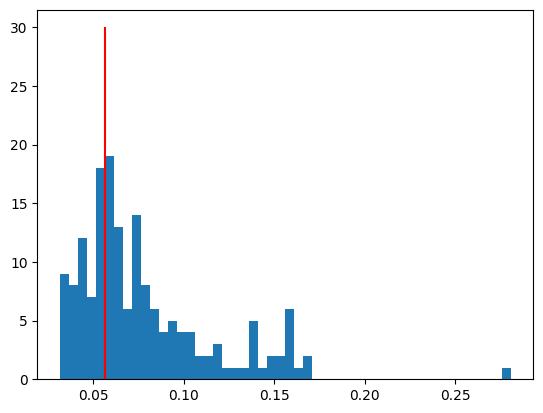

In [ ]:
plt.hist(y_score,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

### Visualization (Results)

AUC-ROC Score: 0.9429896344789962


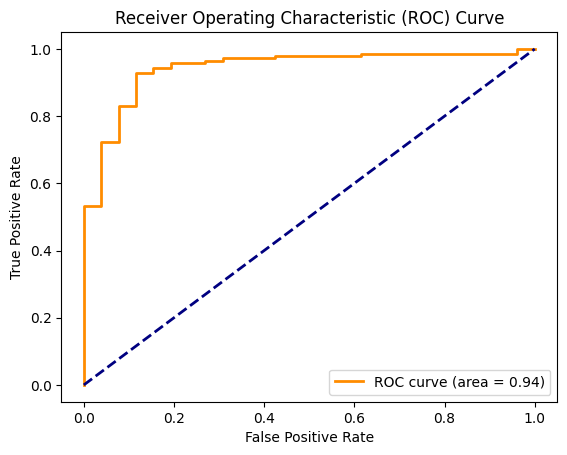

best_threshold = 0.04624652862548828


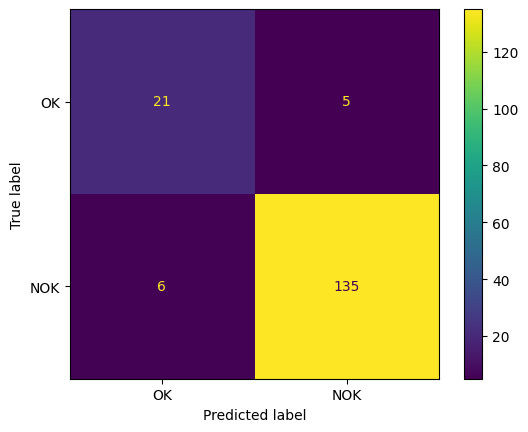

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn as sns



# Calculate AUC-ROC score for the anomaly detection system
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot the Receiver Operating Characteristic (ROC) curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Calculate F1-scores for all possible thresholds to find the optimal one
f1_scores = [f1_score(y_true, y_score >= threshold) for threshold in thresholds]

# Select the best threshold based on the maximum F1 score
best_threshold = thresholds[np.argmax(f1_scores)]

print(f'best_threshold = {best_threshold}')

# Generate and display the confusion matrix using the best threshold
cm = confusion_matrix(y_true, (y_score >= best_threshold).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['OK','NOK']) # Display labels for clarity
disp.plot()
plt.show()


#Anomaly Detection (KNN Distance)

To detect anomalies, we calculate the distance between a test image's features and the nearest normal features we just saved.

Small Distance: The test image looks like the normal ones (Normal).

Large Distance: The test image is far from known normal examples (Anomaly).

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

### Load a pretrained Resnet Model

In [ ]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT) # Load a pre-trained ResNet-50 model

# Create a feature extraction model by removing the final classification layer
model = torch.nn.Sequential(*list(resnet_model.children())[:-1]).cuda() # Move model to GPU
model.eval() # Set the model to evaluation mode

# Freeze all parameters of the ResNet model
for param in model.parameters():
    param.requires_grad = False

del resnet_model # Delete the original ResNet model to free up memory


### Prepare data transformations

In [ ]:
transform = ResNet50_Weights.DEFAULT.transforms()

### Visualize embeddings

In [ ]:
class_labels = [] # To store the class label for each sample
y_true = []       # To store the true binary label (0: good, 1: anomalous)
resnet_features = [] # To store the extracted ResNet features

# Iterate through different classes (good and various anomaly types) in the test dataset
for classes in ['color','good','crack','contamination','faulty_imprint','pill_type','scratch']:
    folder_path = Path('/content/data/pill/test/{}'.format(classes))

    # Iterate through each image file in the current class folder
    for pth in tqdm(folder_path.iterdir(),leave=False):

        class_label = pth.parts[-2] # Get the class label from the path (e.g., 'good', 'color')
        with torch.no_grad():
            test_image = transform(Image.open(pth)).cuda().unsqueeze(0) # Load, transform, and move image to GPU
            features = model(test_image) # Extract features using the pre-trained ResNet model
            resnet_features.append(features.squeeze().cpu().detach().numpy()) # Squeeze, move to CPU, detach, and convert to NumPy array

        class_labels.append(class_label)
        y_true.append(0 if class_label == 'good' else 1) # Assign true label (0 for good, 1 for anomalous)

resnet_features = np.array(resnet_features) # Convert the list of features to a NumPy array


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

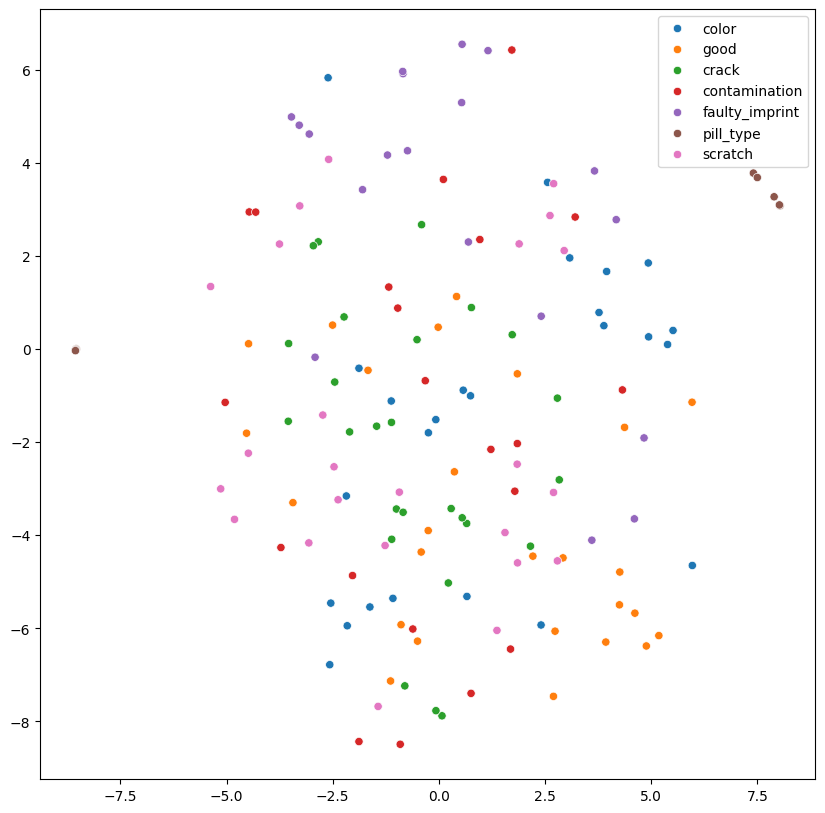

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# Perform t-SNE to reduce the dimensionality of ResNet features to 2 components
tsne = TSNE(n_components=2, random_state=42)
resnet_features_2d = tsne.fit_transform(resnet_features)

# Plot the 2D t-SNE embeddings
plt.figure(figsize=(10,10))
sns.scatterplot(x=resnet_features_2d[:,0],y=resnet_features_2d[:,1],hue=class_labels) # Color points by class label
plt.title('t-SNE Visualization of ResNet Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


### Building the Memory Bank

A Memory Bank is a stored collection (matrix) of feature vectors extracted from all the "normal" training images.

It serves as the reference dataset representing "normality." When testing a new image, the system compares its features against this bank to determine if it is similar (normal) or distant (anomalous).

In [ ]:
memory_bank =[] # Initialize an empty list to store features for the memory bank

folder_path = Path(r'/content/data/pill/train/good') # Path to the 'good' training images

# Iterate through all 'good' images in the training set
for pth in tqdm(folder_path.iterdir(),leave=False):

    with torch.no_grad(): # Disable gradient calculation
        data = transform(Image.open(pth)).cuda().unsqueeze(0) # Load, transform, and move image to GPU
        features = model(data) # Extract features using the pre-trained ResNet model
        memory_bank.append(features.squeeze().cpu().detach()) # Squeeze, move to CPU, detach, and append to list

memory_bank = torch.stack(memory_bank).cuda() # Stack all features to create a single tensor and move to GPU


0it [00:00, ?it/s]

### Plot the std of columns in the memory bank

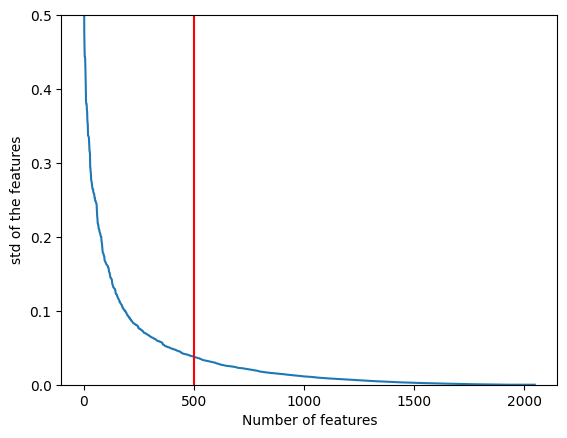

In [ ]:
values,indices = torch.sort(memory_bank.std(dim=0))

plt.plot(values.cpu().numpy()[::-1])
plt.vlines(x=500,ymin=0,ymax=0.5,colors='red')
plt.ylim([0,0.5])
plt.ylabel("std of the features")
plt.xlabel("Number of features")
plt.show()

In [ ]:
values,indices = torch.sort(memory_bank.std(dim=0)) # Sort features based on their standard deviation
selected_indices = indices[-500:] # Select the top 500 features with the highest standard deviation
memory_bank = memory_bank[:,selected_indices] # Update the memory bank to include only selected features


In [ ]:
memory_bank.shape

torch.Size([267, 500])

### For Good images [K nearsest neighbours]

In [ ]:
y_score=[]

k=50

folder_path = Path('/content/data/pill/train/good')

for pth in tqdm(folder_path.iterdir(),leave=False):
    data = transform(Image.open(pth)).cuda().unsqueeze(0)
    with torch.no_grad():
        features = model(data).squeeze()
    dist,_=torch.sort(torch.norm(memory_bank - features[selected_indices], dim=1))# Calculating the pair-wise distance between the sample and memory bank
    dist = dist[:k].mean()# K nearsest neighbours
    y_score.append(dist.cpu().numpy())

0it [00:00, ?it/s]

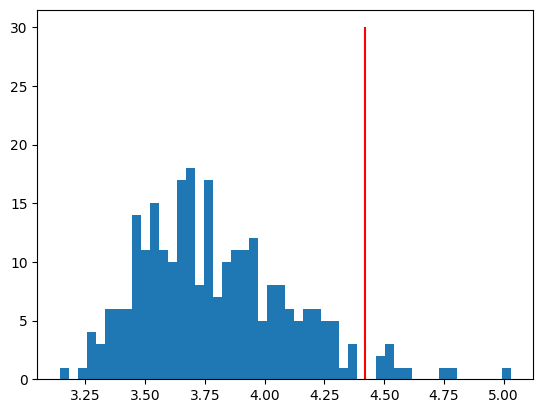

In [ ]:
best_threshold = np.mean(y_score) + 2 * np.std(y_score)

plt.hist(y_score,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

### For bad  Images

In [ ]:
folder_path = Path('/content/data/pill/test/color')

class_labels = []
y_true = []
resnet_features = []
y_score = []

for classes in ['color','good','crack','contamination','faulty_imprint','pill_type','scratch']:
    folder_path = Path(r'/content/data/pill/test/{}'.format(classes))

    for pth in tqdm(folder_path.iterdir(),leave=False):

        class_label = pth.parts[-2]
        with torch.no_grad():
            test_image = transform(Image.open(pth)).cuda().unsqueeze(0)
            features = model(test_image).squeeze()
            dist,_=torch.sort(torch.norm(memory_bank - features[selected_indices], dim=1))#[-10:].mean()
            dist = dist[:k].mean()
            y_score.append(dist.cpu().numpy())

        class_labels.append(class_label)
        y_true.append(0 if class_label == 'good' else 1)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

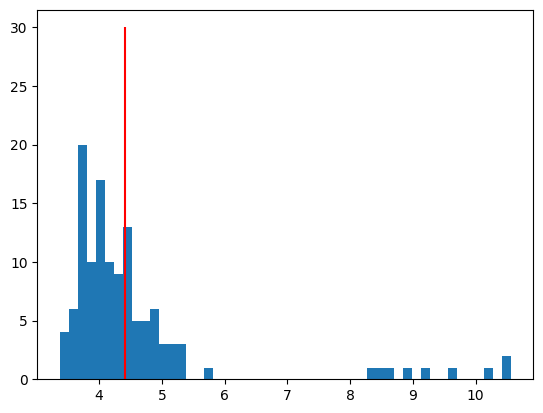

In [ ]:
y_score_nok = [score  for score,true in zip(y_score,y_true) if true==1]
plt.hist(y_score_nok,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

### Evaluation matrix

AUC-ROC Score: 0.6851736972704715


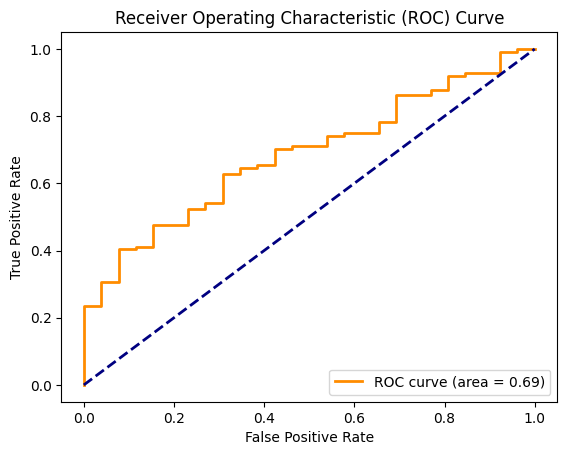

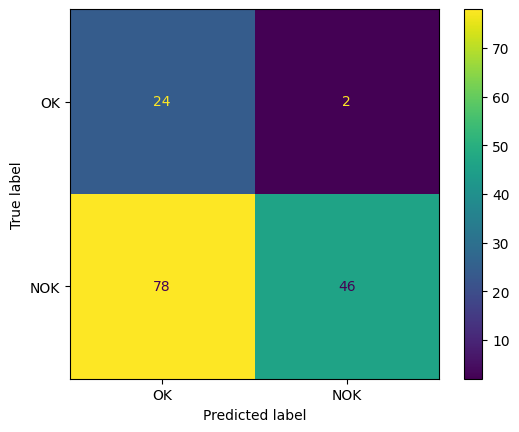

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score


# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



# Generate confusion matrix
cm = confusion_matrix(y_true, (y_score >= best_threshold).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['OK','NOK'])
disp.plot()
plt.show()

# Patch comparison

#### Patch Comparison Techniques

Patch comparison techniques move beyond the simple question:

> **“Is this whole image normal?”**

Instead, they ask a much more precise question:

> **“Is this specific 16×16 pixel patch normal?”**

This distinction is crucial for detecting **small, localized defects**—such as a tiny scratch on a pill—that might otherwise be *averaged out* or missed entirely in a global image analysis.

---

#### Why Patches Matter

Global image analysis can overlook subtle abnormalities because it evaluates the image as a whole. Patch-based methods, however, focus on **fine-grained details**, making them far more effective at identifying small defects.

---

#### The Concept: The Mosaic Analogy

Imagine a **“normal” image** as a completed **mosaic puzzle**.

##### Global Approach (e.g., Previous ResNet Model)

You step back and squint at the entire puzzle and ask:

> *“Does the overall picture look right?”*

Small errors may go unnoticed because the big picture still appears correct.

---

##### Patch-Based Approach

Now, take the puzzle apart and examine **each individual piece**. For every piece, you ask:

> *“Have I seen a piece shaped and colored exactly like this before in a normal puzzle?”*

* 🟦 **Blue sky piece**
  If you’ve seen many blue sky pieces before → **Normal**

* 🟥 **Red scratch piece**
  If you’ve never seen a piece like this before → **Anomaly**

---

#### Key Insight

By evaluating **each patch independently**, patch comparison techniques can detect subtle, localized anomalies that global approaches often miss.


### Load a pretrained Resnet Model

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [ ]:
class resnet_feature_extractor(torch.nn.Module):
    def __init__(self):
        """This class extracts the feature maps from a pretrained Resnet model and reshapes them for patch comparison."""
        super(resnet_feature_extractor, self).__init__()
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)

        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False

        # Hook to extract feature maps
        self.features = [] # List to store extracted feature maps
        def hook(module, input, output) -> None:
            """This hook saves the extracted feature map on self.features."""
            self.features.append(output)

        # Register forward hooks to capture feature maps from specific layers
        self.model.layer2[-1].register_forward_hook(hook)
        self.model.layer3[-1].register_forward_hook(hook)

    def forward(self, input):

        self.features = [] # Clear features from previous runs
        with torch.no_grad(): # Disable gradient calculation
            _ = self.model(input) # Pass input through the model

        # Apply average pooling and resize feature maps
        self.avg = torch.nn.AvgPool2d(3, stride=1)
        fmap_size = self.features[0].shape[-2]         # Feature map sizes h, w
        self.resize = torch.nn.AdaptiveAvgPool2d(fmap_size) # Resize all feature maps to a consistent size

        # Resize and concatenate the feature maps
        resized_maps = [self.resize(self.avg(fmap)) for fmap in self.features]
        patch = torch.cat(resized_maps, 1)            # Merge the resized feature maps

        # Reshape the concatenated feature maps into a column tensor for patch-wise comparison
        # This effectively treats each spatial location as a 'patch' feature vector
        patch = patch.reshape(patch.shape[1], -1).T   # Create a tensor where each row is a patch feature vector

        return patch


In [ ]:
image = Image.open('/content/data/pill/test/color/000.png')
image = transform(image).unsqueeze(0).cuda()

backbone = resnet_feature_extractor().cuda()
feature = backbone(image)

# print(backbone.features[0].shape)
# print(backbone.features[1].shape)

print(feature.shape)

torch.Size([784, 1536])


### Create memory bank from 'normal' data

In [ ]:
memory_bank =[]

folder_path = Path('/content/data/pill/train/good')

for pth in tqdm(folder_path.iterdir(),leave=False):

    with torch.no_grad():
        data = transform(Image.open(pth)).cuda().unsqueeze(0)
        features = backbone(data)
        memory_bank.append(features.cpu().detach())

memory_bank = torch.cat(memory_bank,dim=0).cuda()

0it [00:00, ?it/s]



---

Only select 10% of total patches to avoid long inference time and computation

---



In [ ]:
selected_indices = np.random.choice(len(memory_bank), size=len(memory_bank)//10, replace=False)
memory_bank = memory_bank[selected_indices]

### For OK images [K nearsest neighbours]

In [ ]:
y_score=[]
folder_path = Path('/content/data/pill/train/good')

for pth in tqdm(folder_path.iterdir(),leave=False):
    data = transform(Image.open(pth)).cuda().unsqueeze(0)
    with torch.no_grad():
        features = backbone(data)
    distances = torch.cdist(features, memory_bank, p=2.0)
    dist_score, dist_score_idxs = torch.min(distances, dim=1)
    s_star = torch.max(dist_score)
    segm_map = dist_score.view(1, 1, 28, 28)

    y_score.append(s_star.cpu().numpy())

0it [00:00, ?it/s]

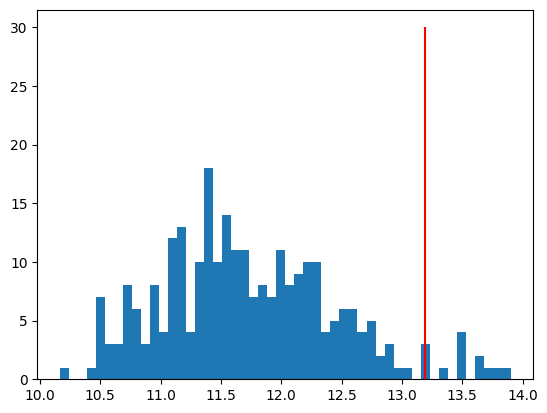

In [ ]:
best_threshold = np.mean(y_score) + 2 * np.std(y_score)

plt.hist(y_score,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

### For NOK Images

In [ ]:
y_score = []
y_true=[]

for classes in ['color','good','crack','contamination','faulty_imprint','pill_type','scratch']:
    folder_path = Path('/content/data/pill/test/{}'.format(classes))

    for pth in tqdm(folder_path.iterdir(),leave=False):

        class_label = pth.parts[-2]
        with torch.no_grad():
            test_image = transform(Image.open(pth)).cuda().unsqueeze(0)
            features = backbone(test_image)

        distances = torch.cdist(features, memory_bank, p=2.0)
        dist_score, dist_score_idxs = torch.min(distances, dim=1)
        s_star = torch.max(dist_score)
        segm_map = dist_score.view(1, 1, 28, 28)

        y_score.append(s_star.cpu().numpy())
        y_true.append(0 if class_label == 'good' else 1)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

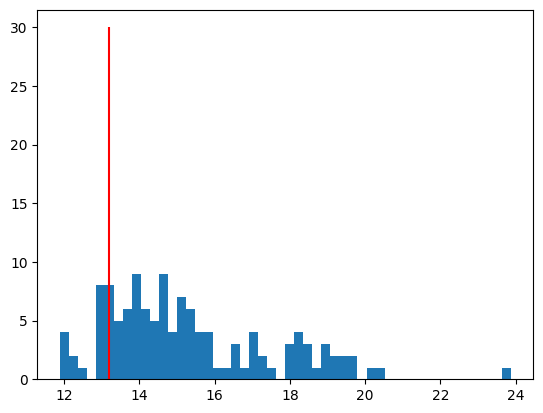

In [ ]:
# plotting the y_score values which do not belong to 'good' class

y_score_nok = [score  for score,true in zip(y_score,y_true) if true==1]
plt.hist(y_score_nok,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

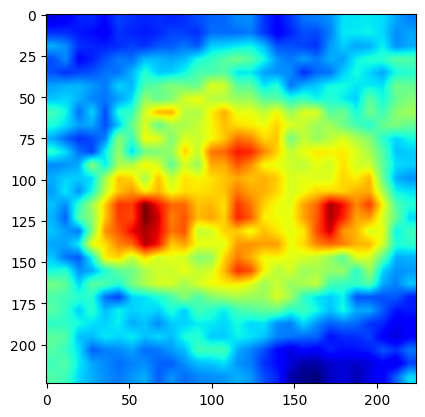

In [ ]:
test_image = transform(Image.open('/content/data/pill/test/color/000.png')).cuda().unsqueeze(0)
features = backbone(test_image)

distances = torch.cdist(features, memory_bank, p=2.0)
dist_score, dist_score_idxs = torch.min(distances, dim=1)
s_star = torch.max(dist_score)
segm_map = dist_score.view(1, 1, 28, 28)

segm_map = torch.nn.functional.interpolate(     # Upscale by bi-linaer interpolation to match the original input resolution
                segm_map,
                size=(224, 224),
                mode='bilinear'
            )

plt.imshow(segm_map.cpu().squeeze(), cmap='jet')

### Evaluation Matrices

AUC-ROC Score: 0.923076923076923


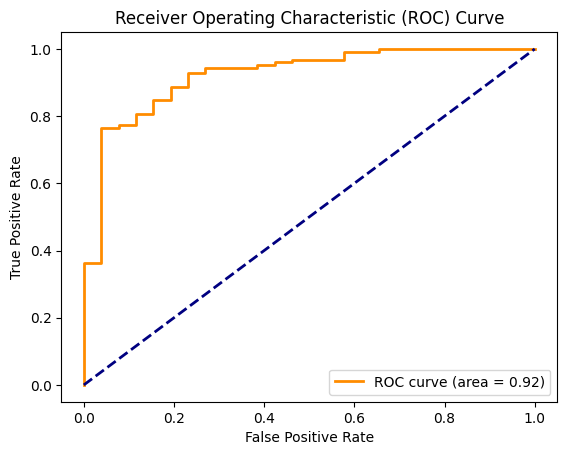

best_threshold = 12.886139869689941


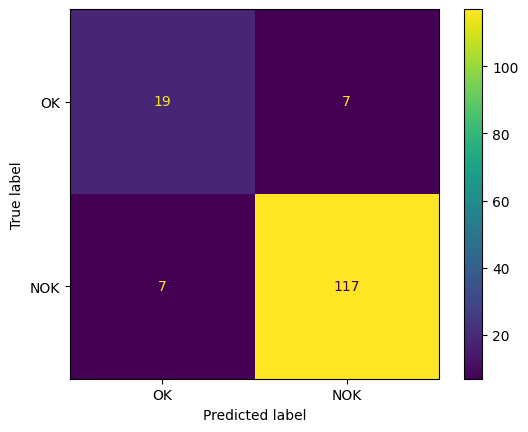

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score


# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

f1_scores = [f1_score(y_true, y_score >= threshold) for threshold in thresholds]

# Select the best threshold based on F1 score
best_threshold = thresholds[np.argmax(f1_scores)]

print(f'best_threshold = {best_threshold}')

# Generate confusion matrix
cm = confusion_matrix(y_true, (y_score >= best_threshold).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['OK','NOK'])
disp.plot()
plt.show()

### Printout the prediction on the test set

In [ ]:
import cv2, time
from IPython.display import clear_output

backbone.eval() # Set the feature extractor to evaluation mode

# NOTE: This code is currently configured for a specific `carpet/test` subdirectory and 'cut' fault type.
# To test other categories or fault types, modify the `test_path` and `if fault_type in ['cut']:` condition.
test_path = Path('carpet/test') # Example path, adjust as needed for different categories

# Iterate through image files in the specified test path
for path in test_path.glob('*/*.png'):

    fault_type = path.parts[-2] # Extract the fault type from the path

    # Only process images belonging to the 'cut' fault type for this example
    # Modify this condition to test other anomaly types or all types
    if fault_type in ['cut']:

        test_image = transform(Image.open(path)).cuda().unsqueeze(0) # Load, transform, and move image to GPU

        with torch.no_grad(): # Disable gradient calculation
            features = backbone(test_image) # Extract patch features using the ResNet backbone

        # Calculate distances between test image patches and the memory bank
        distances = torch.cdist(features, memory_bank, p=2.0) # Using L2 norm

        # Find the minimum distance for each test patch to its nearest neighbor in the memory bank
        dist_score, dist_score_idxs = torch.min(distances, dim=1)

        # The anomaly score for the image is the maximum of these minimum distances
        s_star = torch.max(dist_score)

        # Reshape the distance scores back into a spatial map (heatmap)
        segm_map = dist_score.view(1, 1, 28, 28)

        # Upscale the segmentation map to the original image resolution for visualization
        segm_map = torch.nn.functional.interpolate(
                    segm_map,
                    size=(224, 224),
                    mode='bilinear'
                ).cpu().squeeze().numpy()

        y_score_image = s_star.cpu().numpy() # Convert anomaly score to NumPy

        # Predict if the image is anomalous based on the best_threshold
        y_pred_image = 1*(y_score_image >= best_threshold)
        class_label = ['OK','NOK'] # Labels for display

        # Plotting the original image, anomaly heatmap, and segmentation map
        plt.figure(figsize=(15,5))

        plt.subplot(1,3,1)
        plt.imshow(test_image.squeeze().permute(1,2,0).cpu().numpy()) # Original image
        plt.title(f'Fault Type: {fault_type}')

        plt.subplot(1,3,2)
        heat_map = segm_map
        plt.imshow(heat_map, cmap='jet',vmin=best_threshold, vmax=best_threshold*2) # Anomaly heatmap
        plt.title(f'Anomaly Score: {y_score_image / best_threshold:0.4f} || {class_label[y_pred_image]}')

        plt.subplot(1,3,3)
        plt.imshow((heat_map > best_threshold*1.25), cmap='gray') # Binary segmentation map
        plt.title(f'Segmentation Map')

        plt.show()

        time.sleep(0.05) # Small delay for visualization
        clear_output(wait=True) # Clear output for dynamic updates
